# Numerov Calculation Script

In [1]:
import numpy as np
import pandas as pd
import scipy.constants as const
import matplotlib.pyplot as plt
import math
from mendeleev.fetch import fetch_table

## Data Read-In

We need the scan file with the dipole moment and we need our numerov.dat file

In [2]:

# df --> numerov dat file
# eigenvalues --> numerov dat file
# scan_dat --> bond scan dat file 
# out_file = define name for output file of mu_squared, oscillatory strength f, k
# molecule name --> define your molecule name 
# Atoms for reduces mass --> Insert your atoms for reduced mass for diatomic systems


molecule_name = "LiH"

atoms_for_red = ["Li","H"]


out_file = "LiH_out.dat"

df = pd.read_csv("numerov.dat", skiprows = 2, names = ["Distances","Energies","Wf_shifted_0","Wf_shifted_1","Wf_shifted_2","Wf_shifted_3","Wf_shifted_4","Wf_0","Wf_1","Wf_2","Wf_3","Wf_4"], sep="\s+")

eigenvalues = pd.read_csv("numerov.dat", skiprows=1, nrows=1, sep="\s+",names=["a","b","c","d","e","f"])

scan_dat = pd.read_csv("LiH_scan_data.dat",sep="\t",names=["Distances", "Energy", "Dipole_vectors_xyz"])

dipole_vectors = scan_dat.loc[:, "Dipole_vectors_xyz"]

# This splits the individual dipole vectors
dipole_vectors_split = dipole_vectors.str.split(r'\s+',expand=True)
dipole_vectors_split = dipole_vectors_split.astype(float)


In [3]:
# Build periodic tablee

def get_mass_information() -> pd.DataFrame:
    """
    Returns atomic mass for all elements using mendeleev
    """
    df = fetch_table("elements")
    mass_info = df.loc[:, ["symbol", "atomic_weight"]]
    deuterium_info = pd.DataFrame({"symbol": ["D"], "atomic_weight": [2.014102]})
    mass_info = pd.concat([mass_info, deuterium_info])
    mass_info.set_index("symbol", inplace=True)
    return mass_info

Mass_info = get_mass_information()

mass_atom_1 = Mass_info.loc[atoms_for_red[0]][0]
mass_atom_2 = Mass_info.loc[atoms_for_red[1]][0]

reduced_mass = (mass_atom_1 * mass_atom_2)/(mass_atom_1 + mass_atom_2)








In [4]:
eigenvalues_numpy = eigenvalues.to_numpy()
eigenvalues_slices = eigenvalues_numpy[0,1:]

# Next of we calculate v_n0

eigenvalue_0 = eigenvalues_slices[0]
print("eigenvalue_0:", eigenvalue_0)


# Now we iterate and calculate all our v_n0s

v_n0 = []
for i, eig in enumerate(eigenvalues_slices):
    if i == 0:
        continue
    else:
        v_n0.append((eig - eigenvalue_0)/const.h * 6.9477e-21) 

# we have to turn this into a wavenumber ws

c = const.speed_of_light * 100 # in cm/s

v_n = []   #v_n in cm^-1
for freq in v_n0:
    v_n.append(freq / c)

print("Wave number in cm⁻1",v_n)
    
# Select all x,y,z values for our dipole moment

mu_x = dipole_vectors_split.loc[:, 0]
mu_y = dipole_vectors_split.loc[:, 1]
mu_z = dipole_vectors_split.loc[:, 2]



# And get the bond distances

distances = df.loc[:, "Distances"]



# Select the Wave_Functions for the y_0 and y_n --> as there are just 4 we can do this manually

wf_0 = df.loc[:, "Wf_0"]
wf_1 = df.loc[:, "Wf_1"]
wf_2 = df.loc[:, "Wf_2"]
wf_3 = df.loc[:, "Wf_3"]
wf_4 = df.loc[:, "Wf_4"]


# Make a integrand function

def calculate_integrand(wf_0,mu_comp,wf_n):
    return np.array(wf_0 * mu_comp*wf_n)

integral_mu_x = []
integral_mu_y = []
integral_mu_z = []

for i in range(1,5):
    wf_0 = df.loc[:, "Wf_0"]
    wf_n = df.loc[:, f"Wf_{i}"]
    integral_mu_x.append(np.trapz(calculate_integrand(wf_0,mu_x,wf_n),distances))
    integral_mu_y.append(np.trapz(calculate_integrand(wf_0,mu_y,wf_n),distances))
    integral_mu_z.append(np.trapz(calculate_integrand(wf_0,mu_z,wf_n),distances))



    
        
# Now we can calculate the transition dipole moment for n=1-4

mu_n_squared = []
mu_n=[]
mu_x2=[]
mu_y2=[]
mu_z2=[]
for i, item in enumerate(integral_mu_x):
    mu_n_squared.append(abs(integral_mu_x[i])**2 + abs(integral_mu_y[i])**2 + abs(integral_mu_z[i])**2)
    mu_n.append(math.sqrt(abs(integral_mu_x[i])**2 + abs(integral_mu_y[i])**2 + abs(integral_mu_z[i])**2))
    mu_x2.append(abs(integral_mu_x[i]))
    mu_y2.append(abs(integral_mu_y[i]))
    mu_z2.append(abs(integral_mu_z[i]))
print("mu_n_squared:", mu_n_squared)

f_n0 = []
for i in range(4):
    f_n0.append((4.702e-7)*mu_n_squared[i]*v_n[i])

print("f_n0  unit[]",f_n0)





        


eigenvalue_0: 2.011027925943
Wave number in cm⁻1 [1364.1631464328418, 2666.0371417358583, 3910.197504427179, 5124.0817217356935]
mu_n_squared: [0.05178475542105323, 0.0002677266612004552, 2.197926570261392e-07, 1.3334708332660399e-07]
f_n0  unit[] [3.321627037042488e-05, 3.356142884633913e-07, 4.041052550674624e-10, 3.2127889186115454e-10]


In [5]:
w_0 = df.loc[:, "Wf_0"]
w_1 = df.loc[:, "Wf_1"]
w_2 = df.loc[:, "Wf_2"]
w_3 = df.loc[:, "Wf_3"]
w_4 = df.loc[:, "Wf_4"]

row1,row2,row3,row4,row5 = [],[],[],[],[]



for i in range(5):
    w_select = df.loc[:, f"Wf_{i}"]
    row1.append(np.trapz(w_0 * w_select, distances))
    row2.append(np.trapz(w_1 * w_select, distances))
    row3.append(np.trapz(w_2 * w_select, distances))
    row4.append(np.trapz(w_3 * w_select, distances))
    row5.append(np.trapz(w_4 * w_select, distances))

row1 = pd.DataFrame(row1)
row2 = pd.DataFrame(row2)
row3 = pd.DataFrame(row3)
row4 = pd.DataFrame(row4)
row5 = pd.DataFrame(row5)

stacked_rows = pd.concat([row1,row2,row3,row4,row5],axis=1)

stacked_rows = stacked_rows.applymap(lambda x: 0 if x < 1E-12 else x)

print("Here a table for easy latex inclusion gets printed")
print(stacked_rows.to_latex())

Here a table for easy latex inclusion gets printed
\begin{tabular}{lrrrrr}
\toprule
 & 0 & 0 & 0 & 0 & 0 \\
\midrule
0 & 1.000000 & 0.000000 & 0.000000 & 0.000000 & 0.000000 \\
1 & 0.000000 & 1.000000 & 0.000000 & 0.000000 & 0.000001 \\
2 & 0.000000 & 0.000000 & 1.000000 & 0.000001 & 0.000000 \\
3 & 0.000000 & 0.000000 & 0.000001 & 1.000000 & 0.000003 \\
4 & 0.000000 & 0.000001 & 0.000000 & 0.000003 & 1.000000 \\
\bottomrule
\end{tabular}



### Harmonic

Harmonic Fit of the potential is plotted and calculated 

In [6]:
energy=df["Energies"]
energy_list=(list(energy))
e_min=min(energy)
index_emin=energy_list.index(e_min)

In [7]:
k=((energy[index_emin-1]-2*e_min+energy[index_emin+1])/((0.01)**2))
print("Force constant in kcal/(mol A**2)", k)

Force constant in kcal/(mol A**2) 150.47840963235


In [8]:
y=df["Energies"]
y_list=list(y)
x=df["Distances"]
x0=x[y_list.index(min(y))]
harmonic=0.5*k*(x-x0)**2

### Plotting

In [9]:
x=df["Distances"]
y_1=df["Energies"]

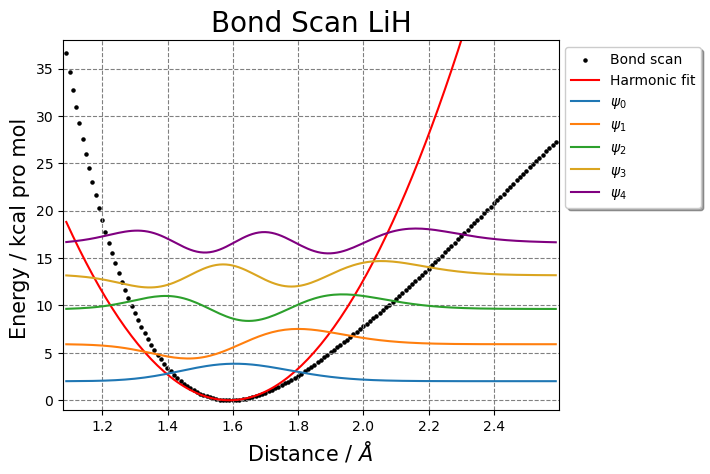

In [25]:
plt.rc("grid", linestyle="dashed", color="grey")
plt.grid(True)
plt.scatter(x,y_1, s=5, c="black", label="Bond scan")
plt.plot(x,harmonic,c="red", label="Harmonic fit")
plt.xlabel(r"Distance / $\AA$ ", size=15)
plt.ylabel("Energy / kcal pro mol ", size=15)
plt.title(f"Bond Scan {molecule_name}", size=20)
plt.plot(x, df['Wf_shifted_0'], label=r"$\psi_0$")
plt.plot(x, df['Wf_shifted_1'], label=r"$\psi_1$")
plt.plot(x, df['Wf_shifted_2'], label=r"$\psi_2$")
plt.plot(x, df['Wf_shifted_3'], label=r"$\psi_3$", c='goldenrod')
plt.plot(x, df['Wf_shifted_4'], label=r"$\psi_4$", c='purple')
plt.ylim(-1, 38)
xmin=min(x)
xmax=max(x)
plt.xlim(xmin-0.01,xmax+0.01)
plt.legend(loc="upper right", bbox_to_anchor=[0.3, 0, 1, 1], shadow=True)
plt.savefig("Bond_scan_LiH_numerov.png", dpi=700, bbox_inches="tight")
plt.show()

In [26]:
energy_cm=df['Energies']*349.757
wf_cm0=df["Wf_shifted_0"]*349.757
wf_cm1=df["Wf_shifted_1"]*349.757
wf_cm2=df["Wf_shifted_2"]*349.757
wf_cm3=df["Wf_shifted_3"]*349.757
wf_cm4=df["Wf_shifted_4"]*349.757
harmonic_cm=harmonic*349.757

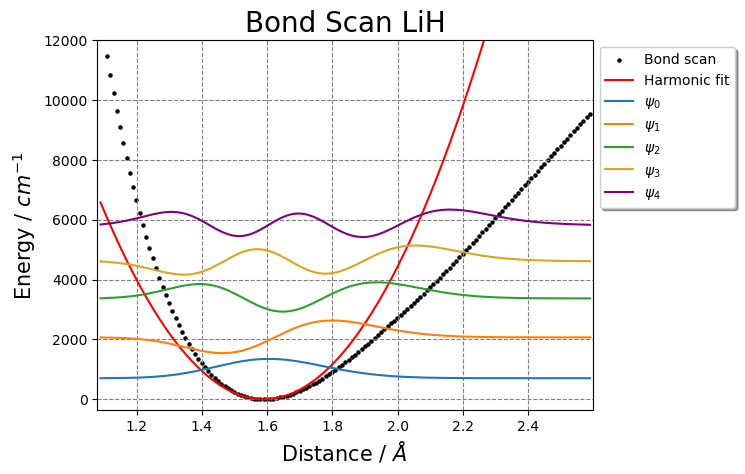

In [28]:
plt.rc("grid", linestyle="dashed", color="grey")
plt.grid(True)
plt.scatter(x,energy_cm, s=5, c="black", label="Bond scan")
plt.plot(x,harmonic_cm,c="red", label="Harmonic fit")
plt.xlabel(r"Distance / $\AA$ ", size=15)
plt.ylabel("Energy / $cm^{-1}$ ", size=15)
plt.title(f"Bond Scan {molecule_name}", size =20)
plt.plot(x, wf_cm0, label=r"$\psi_0$")
plt.plot(x, wf_cm1, label=r"$\psi_1$")
plt.plot(x, wf_cm2, label=r"$\psi_2$")
plt.plot(x, wf_cm3, label=r"$\psi_3$", c="goldenrod")
plt.plot(x, wf_cm4, label=r"$\psi_4$", c="purple")
plt.legend(loc="upper right", bbox_to_anchor=[0.3, 0, 1, 1], shadow=True)
plt.ylim(-350, 12000)
xmin=min(x)
xmax=max(x)
plt.xlim(xmin-0.01,xmax+0.01)
plt.savefig("Bond_scan_LiH_cm_numerov.png", dpi=700, bbox_inches="tight")
plt.show()

### Dipolemoment

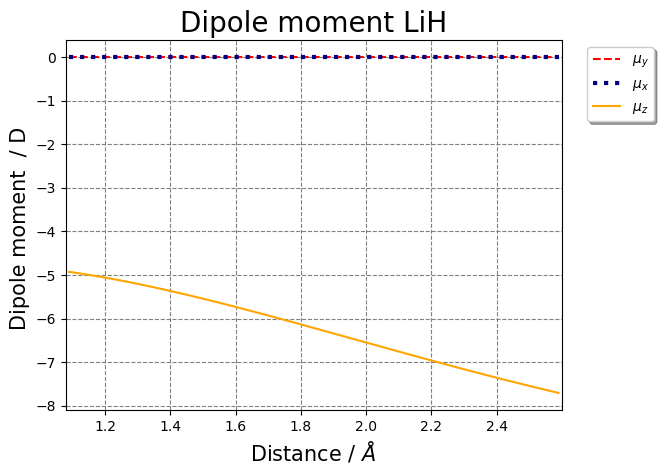

In [29]:
plt.rc("grid", linestyle="dashed", color="grey")
plt.grid(True)
#plt.plot(x, mu_x+mu_y+mu_z, label=r"$\mu_{total}$", c="red")
plt.plot(x, mu_y, label=r"$\mu_{y}$", c="red", linestyle="dashed")
plt.plot(x, mu_x, label=r"$\mu_{x}$", c="navy", linestyle="dotted", linewidth=3)
plt.plot(x, mu_z, label=r"$\mu_{z}$", c="orange")
plt.legend(bbox_to_anchor=[0.2, 0, 1, 1], shadow=True)
plt.xlabel("Distance")
plt.xlabel(r"Distance / $\AA$ ", size=15)
plt.ylabel("Dipole moment  / D ", size=15)
plt.title(f"Dipole moment {molecule_name}",size=20)
xmin=min(x)
xmax=max(x)
plt.xlim(xmin-0.01,xmax+0.01)
plt.savefig("dipole_moment_trans_formic_acid_D.png", dpi=700, bbox_inches="tight")

In [20]:
g=open(out_file, "w")
print("mu_n_squared: Deybe**2 ", mu_n_squared, file=g)
print("f_n0 []:",f_n0, file=g)
print("Force constant in kcal/(mol A**2)", k, file=g)
try:
    print("Reduced mass (only for diatomic) diatomic  (g/mol)", reduced_mass, file=g)
except NameError:
    pass    
g.close()
